In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from igrf_utils.IGRF import magn_field_ECI_with_DCM, DCM_ECEF_to_ECI

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']})
rc('text', usetex=True)

%matplotlib inline

In [28]:
# # first get all lines from file
# with open('my_telemetry.txt', 'r') as f:
#     lines = f.readlines()

# # remove spaces
# lines = [line.replace(' ', '') for line in lines]
# lines = [line.replace(';', ' ') for line in lines]

# # finally, write lines in the file
# with open('my_telemetry.txt', 'w') as f:
#     f.writelines(lines)

# Interpolation

### Eart-Centered Inertial RF

Magnetic field (direct dipole) in the ECI reference frame:

$$\textbf{B}_{\text{ECI}} = \dfrac{\mu_e \mu_0}{4 \pi R^5} \left( 3 \left( \textbf{k} \cdot \textbf{R} \right) \textbf{R} - R^2 \textbf{k} \right)$$

$$\begin{align} \text{where:} \qquad \textbf{R} &- \text{radius-vector to the measurement point} \\ \textbf{k} &- \text{Earth dipole vector} \\ R &- \text{absolute value of }\textbf{R} \\ \mu_e &- \text{magnetic dipole moment of the Earth} \\ \mu_0 &- \text{vacuum permeability} \end{align}$$

Earth dipole vector $\textbf{k}$ in this reference frame is simple:

$$\textbf{k} = \begin{pmatrix} 0 \\ 0 \\ -1 \end{pmatrix}$$

### ECI RF $\rightarrow$ Center of mass Orbital RF

The Direction Cosine Matrix of transition from ECI reference frame to center of mass orbital frame is (explanation in the presentation):

$$\textbf{A}_{\text{ECI}\rightarrow\text{Orb}} = \begin{pmatrix} -\sin{u} & \cos{u} \cos{i} & \cos{u} \sin{i} \\ 0 & -\sin{i} & \cos{i} \\ \cos{u} & \sin{u} \cos{i} & \sin{u} \sin{i} \end{pmatrix}$$

$$\begin{align} \text{where:} \qquad i &- \text{inclination of the orbit} \\ u &- \text{argument of latitude for the center of mass} \end{align}$$

Earth dipole vector $\textbf{k}$ in center of mass orbital reference frame becomes:

$$\textbf{k}_{\text{center of mass orbital}} = - \begin{pmatrix} \cos{u} \sin{i} \\ \cos{i} \\ \sin{u} \sin{i} \end{pmatrix}$$

In [2]:
incl = 87 * np.pi / 180                            # [rad] inclination of the orbit
alt = 500e+3

def DCM_ECI_to_ORB(u,i=incl):
    
    return np.array([[-np.sin(u),np.cos(u)*np.cos(i),np.cos(u)*np.sin(i)],
                     [0,-np.sin(i),np.cos(i)],
                     [np.cos(u),np.sin(u)*np.cos(i),np.sin(u)*np.sin(i)]])

### Magnetic field of the $j^\text{th}$ satellite of the swarm in the reference point orbital frame (which moves along the circular orbit)

$$\textbf{B}^j_{\text{ref orbital}} = \dfrac{\mu_e \mu_0}{4 \pi R_j^3} \left[ \dfrac{3}{R_j^2} \left( \textbf{R}_j \cdot \textbf{k}_{\text{ref orbital}} \right) \textbf{R}_j - \textbf{k}_{\text{ref orbital}}\right]$$

where

$$i - \text{inclination of the orbit}$$

$$u - \text{argument of latitude of the satellite on the orbit}$$

$$\textbf{k}_{\text{ref orbital}} = - \begin{pmatrix} \cos{u} \sin{i} \\ \cos{i} \\ \sin{u} \sin{i} \end{pmatrix} - \text{Earth dipole vector in the reference orbital frame}$$

$$\textbf{R}_0 = \begin{pmatrix} 0 \\ 0 \\ R_0 \end{pmatrix} - \text{radius-vector of the swarm's reference point in its own orbital frame}$$

$$\Delta \textbf{R}_j = \begin{pmatrix} a \\ b \\ c \end{pmatrix} - \text{vector from the reference point to the } j^\text{th} \text{ satellite of the swarm in the reference orbital frame}$$

$$\textbf{R}_j = \textbf{R}_0 + \Delta \textbf{R}_j = \begin{pmatrix} a \\ b \\ R_0 + c \end{pmatrix} - \text{radius-vector to the $j$-th satellite of the swarm in the reference orbital frame}$$

$$R_j - \text{absolute value of }\textbf{R}_j$$

In [3]:
MU_0 = 1.257e-6                                # [N / A^2] vacuum permeability
MU_e = 7.94e+22                                # [A * m^2] magnetic dipole moment of the Earth

def B_j_ref_orb(R, u, i=incl, mu_e = MU_e * MU_0 / (4 * np.pi)):
    
    """
    R -- radius-vector to the j-th satellite of the swarm in the reference orbital frame
    """
    
    k = np.array([np.cos(u) * np.sin(i), np.cos(i), np.sin(u) * np.sin(i)])
    
    kr = k @ R
    
    r = np.linalg.norm(R)
    
    return (k - 3 * kr * R / r**2.) * mu_e / r**3.

### Directional Cosine Matrix (DCM), which converts vector from the orbital frame of the reference satellite to the orbital frame of the $j^\text{th}$ satellite

$$\textbf{A}_{0 \rightarrow j} = \begin{pmatrix} \dfrac{R_0 + c}{R^{\omega}_j} & 0 & -\dfrac{a}{R^{\omega}_j} \\ -\dfrac{ab}{R_j R^{\omega}_j} & \dfrac{R^{\omega}_j}{R_j} & -\dfrac{b (R_0 + c)}{R_j R^{\omega}_j} \\ \dfrac{a}{R_j} & \dfrac{b}{R_j} & \dfrac{R_0 + c}{R_j} \end{pmatrix}$$

where

$$\textbf{R}^{\omega}_j = \begin{pmatrix} R_0 + c \\ 0 \\ -a \end{pmatrix} - \text{auxiliary vector of the } j^\text{th} \text{satellite, which is collinear to its linear velocity, in the reference orbital frame}$$

$$R^{\omega}_j - \text{absolute value of }\textbf{R}^{\omega}_j$$

In [4]:
def A_orb_0_to_j(R):
    
    """
    R -- radius-vector to the j-th satellite of the swarm in the reference orbital frame
    """
    
    R_w = np.copy(R)
    R_w[0] = R[2]
    R_w[1] = 0.
    R_w[2] = -R[0]
    
    r = np.linalg.norm(R)
    r_w = np.linalg.norm(R_w)
    
    A_x = R_w / r_w
    A_y = np.array([-R[0]*R[1] / r_w, r_w, -R[1]*R[2] / r_w]) / r
    A_z = R / r
    
    A = np.vstack((A_x, A_y, A_z))
    
    return A

### Magnetic field of the $j^\text{th}$ satellite of the swarm in its own orbital frame

$$\textbf{B}^j_{\text{own orbital}} = \textbf{A}_{0 \rightarrow j} \textbf{B}^j_{\text{ref orbital}}$$

$$\textbf{B}^j_{\text{own orbital}} = -\dfrac{\mu_e \mu_0}{4 \pi R_j^3} \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & -2 \end{pmatrix} \textbf{A}_{0 \rightarrow j} \textbf{k}_{\text{ref orbital}}$$

In [5]:
def B_j_own_orb(R, u, i=incl, mu_e = MU_e * MU_0 / (4 * np.pi)):
    
    """
    R -- radius-vector to the j-th satellite of the swarm in the reference orbital frame
    """
    
    k = np.array([np.cos(u) * np.sin(i), np.cos(i), np.sin(u) * np.sin(i)])
    
    A = A_orb_0_to_j(R)
    A_11n2 = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., -2.]])
    
    r = np.linalg.norm(R)
    
    return A_11n2 @ A @ k * mu_e / r**3.

### Inverse Distance Weighting

$$
\widehat{\mathbf{B}}\left( \mathbf{R}_\text{int} \right) = \left\{
\begin{aligned}
    \dfrac{\sum\limits_i w_i \mathbf{B} \left( \mathbf{R}_i \right)}{\sum\limits_i w_i}, \quad &\text{if } \forall i: d \left( \mathbf{R}_\text{int}, \mathbf{R}_i \right) \not = 0,\\
    \mathbf{B} \left( \mathbf{R}_i \right), \quad &\text{if } \exists i: d \left( \mathbf{R}_\text{int}, \mathbf{R}_i \right)  = 0.
\end{aligned}
\right.
$$

where

$$d \left( \mathbf{R}_\text{int}, \mathbf{R}_i \right) - \text{distance between points } \mathbf{R}_\text{int} \text{ and } \mathbf{R}_i$$

$$w_i = d \left( \mathbf{R}_\text{int}, \mathbf{R}_i \right)^{-p} - \text{weight of the point } \mathbf{R}_i$$

$$p - \text{power parameter}$$

In [6]:
def idw(Bs, Rs, R_int, p):
    
    """
    Bs -- array of magnetic fields in points, corresponding to Rs
    Rs -- array of radius-vectors
    R_int -- radius-vector to the point of interpolation
    p -- power parameter of the IDW
    
    everything in the reference orbital frame
    """
    
    delt = Rs - R_int
    w = np.zeros(len(delt))
    B_int = np.zeros_like(Bs[0])
    coef_sum = 0.
    
    for (i, delt_i) in enumerate(delt):
        
        r_i = np.linalg.norm(delt_i)
        
        if r_i == 0:
            return Bs[i]
        
        w[i] = r_i**(-p)
        B_int += Bs[i] * w[i]
        coef_sum += w[i]
        
    return B_int / coef_sum

### Interpolation with IDW

$\textbf{Input:}$ inclination $i$, argument of latitude $u$, radius-vectors to all satellites in the swarm $\mathbf{R}^j_\text{ref orbital}$ in reference point orbital frame, power parameter $p$.

$1$. Calculate magnetic field of the $j^\text{th}$ satellite of the swarm in the reference point orbital frame: $\mathbf{B}^j_\text{ref orbital}$

$2$. Interpolate magnetic field in each point $\mathbf{R}^j_\text{ref orbital}$: $\widehat{\mathbf{B}}^j_\text{ref orbital} = \text{idw} \left( \mathbf{B}_i, \mathbf{R}_i \right), i \not = j$

$3$. Compare true value $\mathbf{B}^j_\text{ref orbital}$ with estimate $\widehat{\mathbf{B}}^j_\text{ref orbital}$

$\textbf{Output:}$ $\mathbf{B}^j_\text{ref orbital}$ and $\widehat{\mathbf{B}}^j_\text{ref orbital}$

In [7]:
def interpolation(Rs, u, p):
    
    Bs_ref = np.zeros_like(Rs, dtype=float)
    Bs_ref_int = np.zeros_like(Rs, dtype=float)
    
    for (i, R) in enumerate(Rs):
        
        Bs_ref[i] = B_j_ref_orb(R, u)
        
    for (i, R) in enumerate(Rs):
        
        Rs_for_int = np.delete(Rs, i, axis=0)
        Bs_for_int = np.delete(Bs_ref, i, axis=0)
        
        Bs_ref_int[i] = idw(Bs_for_int, Rs_for_int, R, p)
        
    return Bs_ref, Bs_ref_int

## Semivariogram models

In [35]:
from scipy.special import kv as mod_bessel
from scipy.special import gamma

In [36]:
def matern(h, c0, c, alpha, nu):
    
    with np.errstate(all='ignore'):
        return np.where(h == 0, 0, c0 + c * (1. - 1. / (2**(nu-1.) * gamma(nu)) * (h / alpha)**nu * mod_bessel(nu, h / alpha)))

def cauchy(h, c0, c, alpha, nu):
    
    return np.heaviside(h, 0) * (c0 + c * (1. - (1. + (h / alpha)**2.)**(-nu)))

def logistic(h, c0, c, alpha):
    
    b = (19. * c - c0) / (alpha**2. * (c + c0))
    a = b * c
    
    return np.heaviside(h, 0) * (c0 + a * h**2. / (1 + b * h**2.))

def power(h, c0, c, nu):
    
    return np.heaviside(h, 0) * (c0 + c * h**nu)

def wave(h, c0, c, alpha):
    
    with np.errstate(all='ignore'):
        return np.where(h == 0, 0, c0 + c * (1 - np.sin(h / alpha) / (h / alpha)))
    
def hole_effect(h, c0, c, alpha):
    
    return np.heaviside(h, 0) * (c0 + c * (1. - np.cos(h / alpha)))

def linear(h, c0, c, alpha):
    
    return np.heaviside(h, 0) * (c0 + np.heaviside(h-alpha, 0.) * (c - c * h / alpha) + c * h / alpha)

def exponential(h, c0, c, alpha):
    
    return np.heaviside(h, 0) * (c0 + c * (1. - np.exp(-3.*h / alpha)))

def gaussian(h, c0, c, alpha):
    
    return np.heaviside(h, 0) * (c0 + c * (1. - np.exp(-(3.*h / alpha)**2.)))

def powered_exponential(h, c0, c, alpha, nu):
    
    return np.heaviside(h, 0) * (c0 + c * (1. - np.exp(-(3.*h / alpha)**nu)))

def circular(h, c0, c, alpha):
    
    with np.errstate(all='ignore'):
        extr = 2*c/np.pi * (h / alpha * np.sqrt(1. - (h / alpha)**2.) + np.arcsin(h / alpha))
    extr = np.nan_to_num(extr)
    
    return np.heaviside(h, 0) * (c0 + np.heaviside(h-alpha, 0.) * (c - extr) + extr)

def spherical(h, c0, c, alpha):
    
    extr = c * (1.5 * h / alpha - 0.5 * (h / alpha)**3.)
    
    return np.heaviside(h, 0) * (c0 + np.heaviside(h-alpha, 0.) * (c - extr) + extr)

In [37]:
x = np.linspace(0, 10, 10000)

### Matern model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c \left( 1 - \dfrac{1}{2^{\nu - 1} \Gamma (\nu)} \left( \dfrac{h}{\alpha} \right)^{\nu} K_{\nu} \left( \dfrac{h}{\alpha} \right) \right)&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

where

$$\Gamma - \text{gamma function}$$

$$K_{\nu} - \text{Modified Bessel function of the second kind of real order } \nu$$

In [38]:
plt.title('Matern semivariograms')
plt.plot(x, matern(x, 0.2, 1., 1., 2.5), label='$\\nu = {}$'.format(2.5))
plt.plot(x, matern(x, 0.2, 1., 1., 1.), label='$\\nu = {}$'.format(1))
plt.plot(x, matern(x, 0.2, 1., 1., 0.4), label='$\\nu = {}$'.format(0.4))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Cauchy model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c \left( 1 - \left( 1 + \left( \dfrac{h}{\alpha} \right)^2 \right)^{-\nu} \right)&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

In [39]:
plt.title('Cauchy semivariograms')
plt.plot(x, cauchy(x, 0.2, 1., 1., 2.5), label='$\\nu = {}$'.format(2.5))
plt.plot(x, cauchy(x, 0.2, 1., 1., 1.), label='$\\nu = {}$'.format(1))
plt.plot(x, cauchy(x, 0.2, 1., 1., 0.4), label='$\\nu = {}$'.format(0.4))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Logistic model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + \dfrac{a h^2}{1 + b h^2}&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

where

$$a = \dfrac{c \left( 19 c - c_0 \right)}{\alpha^2 \left( c + c_0 \right)}$$

$$b = \dfrac{19 c - c_0}{\alpha^2 \left( c + c_0 \right)}$$

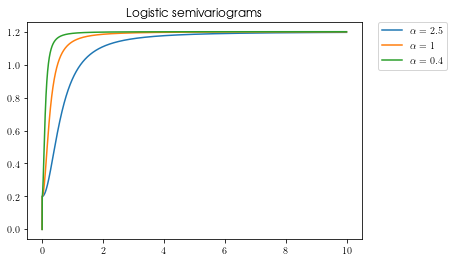

In [40]:
plt.title('Logistic semivariograms')
plt.plot(x, logistic(x, 0.2, 1., 2.5), label='$\\alpha = {}$'.format(2.5))
plt.plot(x, logistic(x, 0.2, 1., 1.), label='$\\alpha = {}$'.format(1))
plt.plot(x, logistic(x, 0.2, 1., 0.4), label='$\\alpha = {}$'.format(0.4))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Power model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c h^{\nu}&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

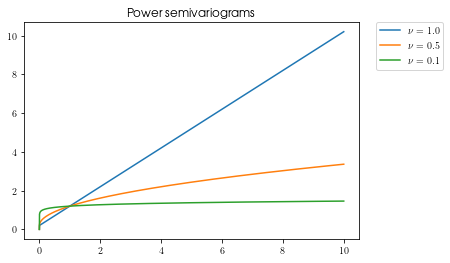

In [41]:
plt.title('Power semivariograms')
plt.plot(x, power(x, 0.2, 1., 1.), label='$\\nu = {}$'.format(1.))
plt.plot(x, power(x, 0.2, 1., 0.5), label='$\\nu = {}$'.format(0.5))
plt.plot(x, power(x, 0.2, 1., 0.1), label='$\\nu = {}$'.format(0.1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Wave model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c \left( 1 - \dfrac{\alpha \sin{\left( \dfrac{h}{\alpha} \right)}}{h} \right)&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

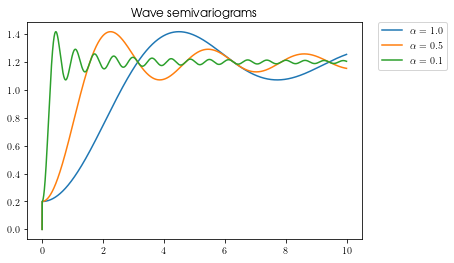

In [42]:
plt.title('Wave semivariograms')
plt.plot(x, wave(x, 0.2, 1., 1.), label='$\\alpha = {}$'.format(1.))
plt.plot(x, wave(x, 0.2, 1., 0.5), label='$\\alpha = {}$'.format(0.5))
plt.plot(x, wave(x, 0.2, 1., 0.1), label='$\\alpha = {}$'.format(0.1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Hole Effect model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c \left( 1 - \cos{\left( \dfrac{h}{\alpha} \right)} \right)&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

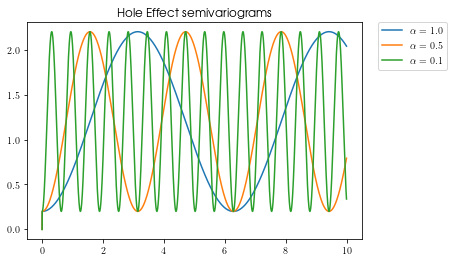

In [43]:
plt.title('Hole Effect semivariograms')
plt.plot(x, hole_effect(x, 0.2, 1., 1.), label='$\\alpha = {}$'.format(1.))
plt.plot(x, hole_effect(x, 0.2, 1., 0.5), label='$\\alpha = {}$'.format(0.5))
plt.plot(x, hole_effect(x, 0.2, 1., 0.1), label='$\\alpha = {}$'.format(0.1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Linear model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c &, \quad h > \alpha,\\
    c_0 + c \left( \dfrac{h}{\alpha} \right)&, \quad 0 < h \leqslant \alpha,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

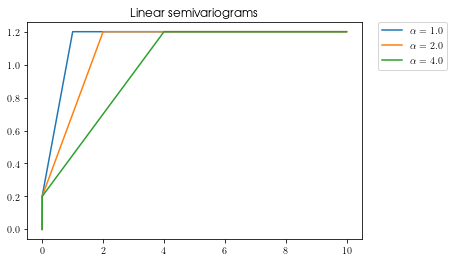

In [44]:
plt.title('Linear semivariograms')
plt.plot(x, linear(x, 0.2, 1., 1.), label='$\\alpha = {}$'.format(1.))
plt.plot(x, linear(x, 0.2, 1., 2.), label='$\\alpha = {}$'.format(2.))
plt.plot(x, linear(x, 0.2, 1., 4.), label='$\\alpha = {}$'.format(4.))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Exponential model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c \left( 1 - \exp{\left( - \dfrac{h}{\alpha} \right)} \right)&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

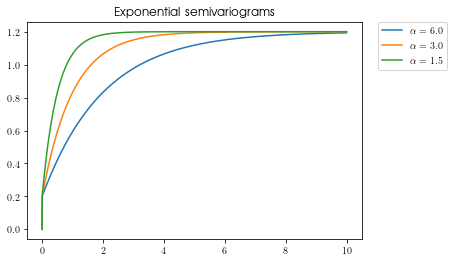

In [45]:
plt.title('Exponential semivariograms')
plt.plot(x, exponential(x, 0.2, 1., 6.), label='$\\alpha = {}$'.format(6.))
plt.plot(x, exponential(x, 0.2, 1., 3.), label='$\\alpha = {}$'.format(3.))
plt.plot(x, exponential(x, 0.2, 1., 1.5), label='$\\alpha = {}$'.format(1.5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Gaussian model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c \left( 1 - \exp{\left( - \left( \dfrac{h}{\alpha} \right)^2 \right)} \right)&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

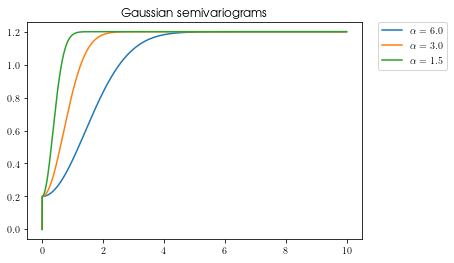

In [46]:
plt.title('Gaussian semivariograms')
plt.plot(x, gaussian(x, 0.2, 1., 6.), label='$\\alpha = {}$'.format(6.))
plt.plot(x, gaussian(x, 0.2, 1., 3.), label='$\\alpha = {}$'.format(3.))
plt.plot(x, gaussian(x, 0.2, 1., 1.5), label='$\\alpha = {}$'.format(1.5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Powered exponential model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c \left( 1 - \exp{\left( - \left( \dfrac{h}{\alpha} \right)^{\nu} \right)} \right)&, \quad h > 0,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

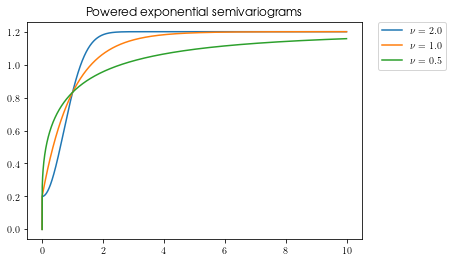

In [47]:
plt.title('Powered exponential semivariograms')
plt.plot(x, powered_exponential(x, 0.2, 1., 3., 2.), label='$\\nu = {}$'.format(2.))
plt.plot(x, powered_exponential(x, 0.2, 1., 3., 1.), label='$\\nu = {}$'.format(1.))
plt.plot(x, powered_exponential(x, 0.2, 1., 3., 0.5), label='$\\nu = {}$'.format(0.5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Circular model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c &, \quad h > \alpha,\\
    c_0 + \dfrac{2c}{\pi} \left( \dfrac{h}{\alpha} \sqrt{1 - \left( \dfrac{h}{\alpha} \right)^2} + \arcsin{\left( \dfrac{h}{\alpha} \right)} \right) &, \quad 0 < h \leqslant \alpha,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

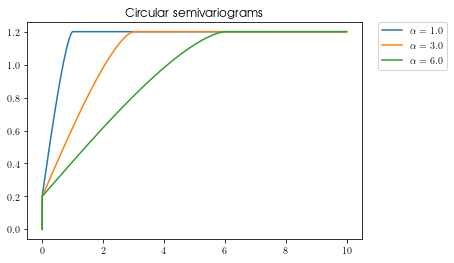

In [48]:
plt.title('Circular semivariograms')
plt.plot(x, circular(x, 0.2, 1., 1.), label='$\\alpha = {}$'.format(1.))
plt.plot(x, circular(x, 0.2, 1., 3.), label='$\\alpha = {}$'.format(3.))
plt.plot(x, circular(x, 0.2, 1., 6.), label='$\\alpha = {}$'.format(6.))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Spherical model

$$\gamma(h) = \left\{
\begin{aligned}
    c_0 + c &, \quad h > \alpha,\\
    c_0 + c \left( \dfrac{3h}{2 \alpha} - \dfrac{1}{2} \left( \dfrac{h}{\alpha} \right)^3 \right) &, \quad 0 < h \leqslant \alpha,\\
    0&, \quad h = 0.
\end{aligned}\right.$$

In [49]:
plt.title('Spherical semivariograms')
plt.plot(x, spherical(x, 0.2, 1., 1.), label='$\\alpha = {}$'.format(1.))
plt.plot(x, spherical(x, 0.2, 1., 3.), label='$\\alpha = {}$'.format(3.))
plt.plot(x, spherical(x, 0.2, 1., 6.), label='$\\alpha = {}$'.format(6.))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Empirical semivariogram

$$\forall \mathbf{R}_i, \mathbf{R}_j : \left| \mathbf{R}_i - \mathbf{R}_j \right| = h$$

$$\gamma (h) = \dfrac{1}{2 n_h} \sum\limits_{(i,j)=1}^{n_h} \left( \mathbf{B} \left( \mathbf{R}_i \right) - \mathbf{B} \left( \mathbf{R}_j \right) \right)^2$$

where

$$n_h - \text{number od sampled points pairs}$$

In [2]:
def emp_var_u(N_points, size, R_orb, u, isIGRF, withNoise, JD=None, std=None):
    
    def roll_cut(arr, dims, roll_num):

        """
        Util function, which cuts the given array in dependency to the number of the rolling points
        :param arr: given array
        :param dims: number of the rolling points
        :param roll_num: number of rolls
        """

        # if there are overlays in rolling combinations
        if (dims % 2 == 0):
            # cut the first and last overlayed elements
            new_arr = arr[1:-roll_num]
        # if there are none
        else:
            # cut only first element
            new_arr = arr[1:]

        return new_arr
    
    # random points in cube of given size
    rs = (np.random.rand(N_points, 3) - 0.5) * 2. * size
    # translation to the area on the orbit
    Rs = rs + np.array([0, 0, R_orb])
    
    # array of magnetic fields to be filled
    Bs = np.zeros((N_points, 3))
    
    # compute magnetic field for each point
    if isIGRF:
        
        ECEF_2_ECI = DCM_ECEF_to_ECI(JD)
        ECI_2_ORB = DCM_ECI_to_ORB(u)
        
        for (i, R) in enumerate(Rs):
        
            R_ECI = ECI_2_ORB.T @ R
            R_ECEF = ECEF_2_ECI.T @ R_ECI
            R1, R2, R3 = R_ECEF

            phi = np.arctan2(R2, R1)
            theta = np.arctan2(np.sqrt(R1**2 + R2**2), R3)
            r = np.sqrt(R1**2 + R2**2 + R3**2)

            B_ECI = magn_field_ECI_with_DCM(JD, r, theta, phi, ECEF_2_ECI)
            Bs[i] = ECI_2_ORB @ B_ECI / 1e9
    
    else:
        
        for (i, R) in enumerate(Rs):

            Bs[i] = B_j_ref_orb(R, u)
            
    if withNoise:
            
            Bs += np.random.normal(0, std, Bs.shape)

    # number of rolls, necessary to compute the inter-vectors
    roll_num = N_points // 2

    # array of inter vectors to be filled
    vecs = np.zeros((1, 3))
    # array of magnetic field differences to be filled
    Bs_diff = np.zeros((1, 3))

    # after each roll
    for i in range(roll_num):
        
        # compute vectors and add them to the array
        #
        # A, B, C, D -- radius-vectors
        # AB = B - A, CA = A - C, DA = A - D, BC = C - B, DB = B - D, CD = D - C -- inter-vectors
        #
        # A   B    C    D     <-- minuend
        # D   A    B    C     <-- subtrahend #1
        # C   D    A    B     <-- subtrahend #2
        # ----------------
        # DA  AB   BC   CD    <-- difference #1
        # CA  DB  {AC} {BD}   <-- difference #2
        
        vecs = np.vstack((vecs, Rs - np.roll(Rs, i+1, axis=0)))
        Bs_diff = np.vstack((Bs_diff, Bs - np.roll(Bs, i+1, axis=0)))

    # in dependency to the number of points (even), cut repeating vectors ({AC} and {BD} in example above)
    vecs = roll_cut(vecs, N_points, roll_num)
    Bs_diff = roll_cut(Bs_diff, N_points, roll_num)

    # lengths of inter-vectors
    norms = np.linalg.norm(vecs, axis=1)
    # semivariances of magnetic field differences
    semivars = 0.5 * np.einsum('ij,ij->i', Bs_diff, Bs_diff)
    
    args = np.argsort(norms)
    
    norms = norms[args]
    semivars = semivars[args]
    
    return norms, semivars

In [3]:
u = np.pi / 3

In [6]:
xe_IGRF, ye_IGRF = emp_var_u(200, 50e3, 6371e+3 + alt, u, True, False, JD=2458940.1933954097)

plt.plot(xe_IGRF / 1e3, ye_IGRF * 1e12, 'o')
plt.title('Empirical semivariogram for IGRF-13 in $u = \pi / 3$')
plt.xlabel('km')
plt.ylabel('$\\mu$T$^2$')
plt.show()

In [7]:
print(xe_IGRF.shape)

(19900,)


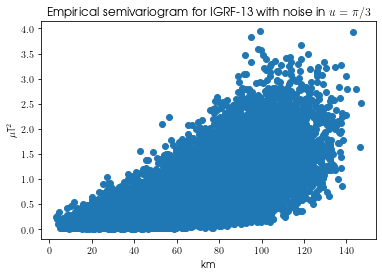

In [53]:
xe_IGRF_noise200, ye_IGRF_noise200 = emp_var_u(200, 50e3, 6371e+3 + alt, u, True, True, JD=2458940.1933954097, std=200e-9)

plt.plot(xe_IGRF_noise200 / 1e3, ye_IGRF_noise200 * 1e12, 'o')
plt.title('Empirical semivariogram for IGRF-13 with noise in $u = \pi / 3$')
plt.xlabel('km')
plt.ylabel('$\\mu$T$^2$')
plt.show()

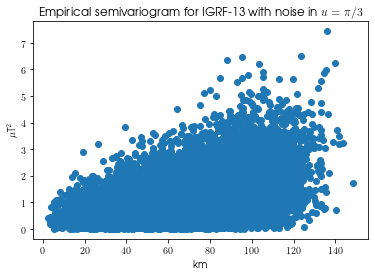

In [54]:
xe_IGRF_noise400, ye_IGRF_noise400 = emp_var_u(200, 50e3, 6371e+3 + alt, u, True, True, JD=2458940.1933954097, std=400e-9)

plt.plot(xe_IGRF_noise400 / 1e3, ye_IGRF_noise400 * 1e12, 'o')
plt.title('Empirical semivariogram for IGRF-13 with noise in $u = \pi / 3$')
plt.xlabel('km')
plt.ylabel('$\\mu$T$^2$')
plt.show()

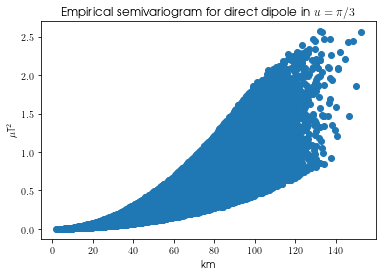

In [55]:
xe_DD, ye_DD = emp_var_u(200, 50e3, 6371e+3 + alt, u, False, False)

plt.plot(xe_DD / 1e3, ye_DD * 1e12, 'o')
plt.title('Empirical semivariogram for direct dipole in $u = \pi / 3$')
plt.xlabel('km')
plt.ylabel('$\\mu$T$^2$')
plt.show()

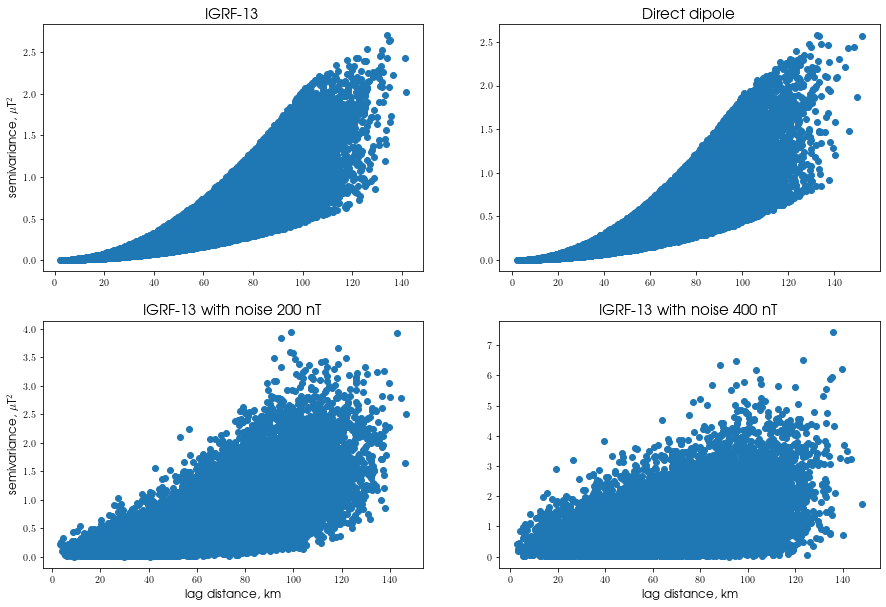

In [56]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 10))

ax1.plot(xe_IGRF / 1e3, ye_IGRF * 1e12, 'o')
ax1.set_title('IGRF-13', fontsize=15)
ax2.plot(xe_DD / 1e3, ye_DD * 1e12, 'o')
ax2.set_title('Direct dipole', fontsize=15)
ax3.plot(xe_IGRF_noise200 / 1e3, ye_IGRF_noise200 * 1e12, 'o')
ax3.set_title('IGRF-13 with noise 200 nT', fontsize=15)
ax4.plot(xe_IGRF_noise400 / 1e3, ye_IGRF_noise400 * 1e12, 'o')
ax4.set_title('IGRF-13 with noise 400 nT', fontsize=15)

ax3.set_xlabel('lag distance, km', fontsize=12)
ax4.set_xlabel('lag distance, km', fontsize=12)
ax1.set_ylabel('semivariance, $\\mu$T$^2$', fontsize=12)
ax3.set_ylabel('semivariance, $\\mu$T$^2$', fontsize=12)

plt.savefig('emp_semivars.pdf', format='pdf', bbox_inches='tight')

plt.show()

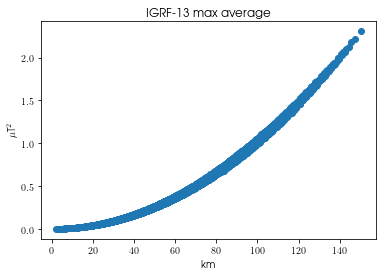

In [57]:
N = 1000
xe_IGRF_av, ye_IGRF_av = np.zeros_like(xe_IGRF), np.zeros_like(ye_IGRF)

for i in range(N):
    
    x, y = emp_var_u(200, 50e3, 6371e+3 + alt, u, True, False, JD=2458940.1933954097)
    
    xe_IGRF_av += x
    ye_IGRF_av += y
    
xe_IGRF_av /= N
ye_IGRF_av /= N

plt.plot(xe_IGRF_av / 1e3, ye_IGRF_av * 1e12, 'o')
plt.title('IGRF-13 max average')
plt.xlabel('km')
plt.ylabel('$\\mu$T$^2$')
plt.show()

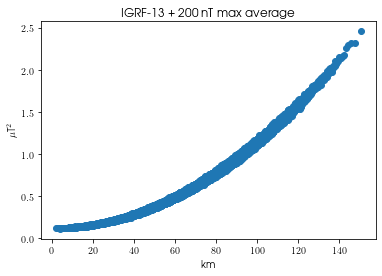

In [58]:
N = 1000
xe_IGRF_noise200_av, ye_IGRF_noise200_av = np.zeros_like(xe_IGRF), np.zeros_like(ye_IGRF)

for i in range(N):
    
    x, y = emp_var_u(200, 50e3, 6371e+3 + alt, u, True, True, JD=2458940.1933954097, std=200e-9)
    
    xe_IGRF_noise200_av += x
    ye_IGRF_noise200_av += y
    
xe_IGRF_noise200_av /= N
ye_IGRF_noise200_av /= N

plt.plot(xe_IGRF_noise200_av / 1e3, ye_IGRF_noise200_av * 1e12, 'o')
plt.title('IGRF-13 + 200 nT max average')
plt.xlabel('km')
plt.ylabel('$\\mu$T$^2$')
plt.show()

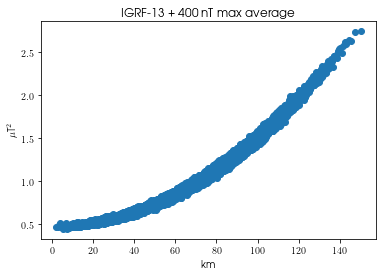

In [59]:
N = 1000
xe_IGRF_noise400_av, ye_IGRF_noise400_av = np.zeros_like(xe_IGRF), np.zeros_like(ye_IGRF)

for i in range(N):
    
    x, y = emp_var_u(200, 50e3, 6371e+3 + alt, u, True, True, JD=2458940.1933954097, std=400e-9)
    
    xe_IGRF_noise400_av += x
    ye_IGRF_noise400_av += y
    
xe_IGRF_noise400_av /= N
ye_IGRF_noise400_av /= N

plt.plot(xe_IGRF_noise400_av / 1e3, ye_IGRF_noise400_av * 1e12, 'o')
plt.title('IGRF-13 + 400 nT max average')
plt.xlabel('km')
plt.ylabel('$\\mu$T$^2$')
plt.show()

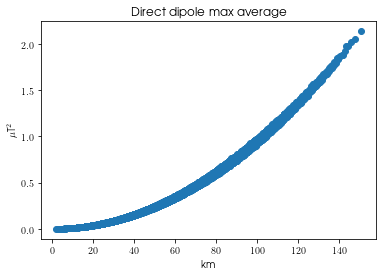

In [60]:
N = 1000
xe_DD_av, ye_DD_av = np.zeros_like(xe_IGRF), np.zeros_like(ye_IGRF)

for i in range(N):
    
    x, y = emp_var_u(200, 50e3, 6371e+3 + alt, u, False, False)
    
    xe_DD_av += x
    ye_DD_av += y
    
xe_DD_av /= N
ye_DD_av /= N

plt.plot(xe_DD_av / 1e3, ye_DD_av * 1e12, 'o')
plt.title('Direct dipole max average')
plt.xlabel('km')
plt.ylabel('$\\mu$T$^2$')
plt.show()

### Averaging empirical semivariogram

In [61]:
def compress_emp_var(n, h, B):
    
    h_cmpr = np.array([])
    B_cmpr = np.array([])

    for i in range(n):

        log = (h > i * h[-1] / float(n)) & (h <= (i+1) * h[-1] / float(n))

        if np.sum(log) != 0:
            h_cmpr = np.hstack((h_cmpr, np.mean(h[log])))
            B_cmpr = np.hstack((B_cmpr, np.mean(B[log])))
            
    return h_cmpr, B_cmpr

In [62]:
N1 = 1000
xe1000_IGRF, ye1000_IGRF = compress_emp_var(N1, xe_IGRF, ye_IGRF)
xe1000_IGRF_noise200, ye1000_IGRF_noise200 = compress_emp_var(N1, xe_IGRF_noise200, ye_IGRF_noise200)
xe1000_IGRF_noise400, ye1000_IGRF_noise400 = compress_emp_var(N1, xe_IGRF_noise400, ye_IGRF_noise400)
xe1000_DD, ye1000_DD = compress_emp_var(N1, xe_DD, ye_DD)

N2 = 100
xe100_IGRF, ye100_IGRF = compress_emp_var(N2, xe_IGRF, ye_IGRF)
xe100_IGRF_noise200, ye100_IGRF_noise200 = compress_emp_var(N2, xe_IGRF_noise200, ye_IGRF_noise200)
xe100_IGRF_noise400, ye100_IGRF_noise400 = compress_emp_var(N2, xe_IGRF_noise400, ye_IGRF_noise400)
xe100_DD, ye100_DD = compress_emp_var(N2, xe_DD, ye_DD)

N3 = 10
xe10_IGRF, ye10_IGRF = compress_emp_var(N3, xe_IGRF, ye_IGRF)
xe10_IGRF_noise200, ye10_IGRF_noise200 = compress_emp_var(N3, xe_IGRF_noise200, ye_IGRF_noise200)
xe10_IGRF_noise400, ye10_IGRF_noise400 = compress_emp_var(N3, xe_IGRF_noise400, ye_IGRF_noise400)
xe10_DD, ye10_DD = compress_emp_var(N3, xe_DD, ye_DD)

N4 = 3000
xe3000_IGRF, ye3000_IGRF = compress_emp_var(N4, xe_IGRF, ye_IGRF)
xe3000_IGRF_noise200, ye3000_IGRF_noise200 = compress_emp_var(N4, xe_IGRF_noise200, ye_IGRF_noise200)
xe3000_IGRF_noise400, ye3000_IGRF_noise400 = compress_emp_var(N4, xe_IGRF_noise400, ye_IGRF_noise400)
xe3000_DD, ye3000_DD = compress_emp_var(N4, xe_DD, ye_DD)

In [63]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 10))
# lgd=fig.suptitle('Empirical semivariogram compression for IGRF-13 in $u = \\pi / 3$', fontsize=18)

ax1.plot(xe3000_IGRF / 1e3, ye3000_IGRF * 1e12, 'o')
ax1.set_title('Average ({} points)'.format(N4), fontsize=15)
ax2.plot(xe1000_IGRF / 1e3, ye1000_IGRF * 1e12, 'o')
ax2.set_title('Average ({} points)'.format(N1), fontsize=15)
ax3.plot(xe100_IGRF / 1e3, ye100_IGRF * 1e12, 'o')
ax3.set_title('Average ({} points)'.format(N2), fontsize=15)
ax4.plot(xe10_IGRF / 1e3, ye10_IGRF * 1e12, 'o')
ax4.set_title('Average ({} points)'.format(N3), fontsize=15)

ax3.set_xlabel('lag distance, km', fontsize=12)
ax4.set_xlabel('lag distance, km', fontsize=12)
ax1.set_ylabel('semivariance, $\\mu$T$^2$', fontsize=12)
ax3.set_ylabel('semivariance, $\\mu$T$^2$', fontsize=12)

plt.savefig('emp_semivars_averaging.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [64]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 10))
lgd=fig.suptitle('Empirical semivariogram compression for IGRF-13 with noise $\\sigma = 200$ nT in $u = \\pi / 3$', fontsize=18)

ax1.plot(xe3000_IGRF_noise200 / 1e3, ye3000_IGRF_noise200 * 1e12, 'o')
ax1.set_title('Average ({} points)'.format(N4), fontsize=15)
ax2.plot(xe1000_IGRF_noise200 / 1e3, ye1000_IGRF_noise200 * 1e12, 'o')
ax2.set_title('Average ({} points)'.format(N1), fontsize=15)
ax3.plot(xe100_IGRF_noise200/ 1e3, ye100_IGRF_noise200 * 1e12, 'o')
ax3.set_title('Average ({} points)'.format(N2), fontsize=15)
ax4.plot(xe10_IGRF_noise200 / 1e3, ye10_IGRF_noise200 * 1e12, 'o')
ax4.set_title('Average ({} points)'.format(N3), fontsize=15)

ax3.set_xlabel('km', fontsize=12)
ax4.set_xlabel('km', fontsize=12)
ax1.set_ylabel('$\\mu$T$^2$', fontsize=12)
ax3.set_ylabel('$\\mu$T$^2$', fontsize=12)

plt.show()

In [65]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 10))
lgd=fig.suptitle('Empirical semivariogram compression for IGRF-13 with noise $\\sigma = 400$ nT in $u = \\pi / 3$', fontsize=18)

ax1.plot(xe3000_IGRF_noise400 / 1e3, ye3000_IGRF_noise400 * 1e12, 'o')
ax1.set_title('Average ({} points)'.format(N4), fontsize=15)
ax2.plot(xe1000_IGRF_noise400 / 1e3, ye1000_IGRF_noise400 * 1e12, 'o')
ax2.set_title('Average ({} points)'.format(N1), fontsize=15)
ax3.plot(xe100_IGRF_noise400/ 1e3, ye100_IGRF_noise400 * 1e12, 'o')
ax3.set_title('Average ({} points)'.format(N2), fontsize=15)
ax4.plot(xe10_IGRF_noise400 / 1e3, ye10_IGRF_noise400 * 1e12, 'o')
ax4.set_title('Average ({} points)'.format(N3), fontsize=15)

ax3.set_xlabel('km', fontsize=12)
ax4.set_xlabel('km', fontsize=12)
ax1.set_ylabel('$\\mu$T$^2$', fontsize=12)
ax3.set_ylabel('$\\mu$T$^2$', fontsize=12)

plt.show()

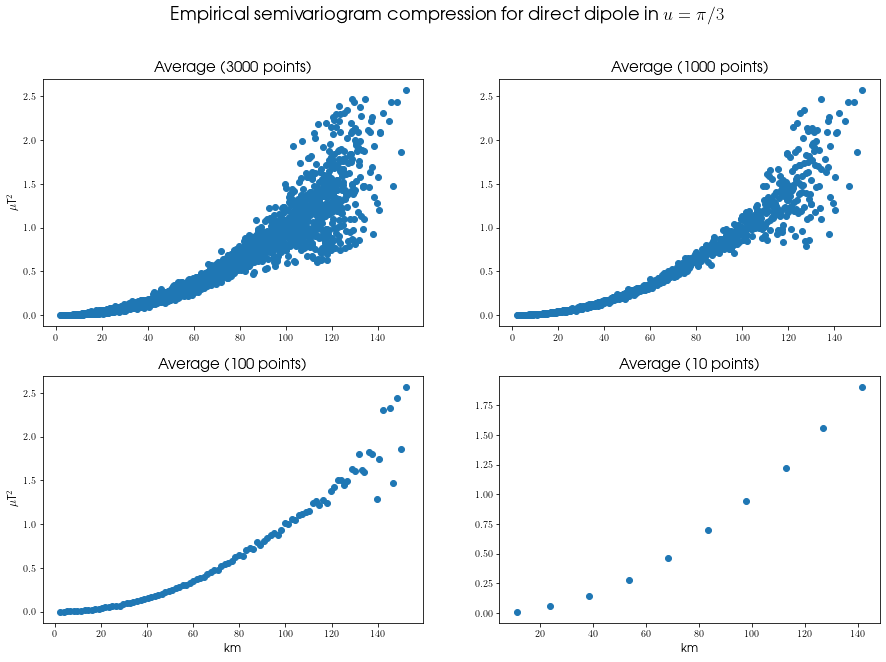

In [66]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 10))
lgd=fig.suptitle('Empirical semivariogram compression for direct dipole in $u = \\pi / 3$', fontsize=18)

ax1.plot(xe3000_DD / 1e3, ye3000_DD * 1e12, 'o')
ax1.set_title('Average ({} points)'.format(N4), fontsize=15)
ax2.plot(xe1000_DD / 1e3, ye1000_DD * 1e12, 'o')
ax2.set_title('Average ({} points)'.format(N1), fontsize=15)
ax3.plot(xe100_DD / 1e3, ye100_DD * 1e12, 'o')
ax3.set_title('Average ({} points)'.format(N2), fontsize=15)
ax4.plot(xe10_DD / 1e3, ye10_DD * 1e12, 'o')
ax4.set_title('Average ({} points)'.format(N3), fontsize=15)

ax3.set_xlabel('km', fontsize=12)
ax4.set_xlabel('km', fontsize=12)
ax1.set_ylabel('$\\mu$T$^2$', fontsize=12)
ax3.set_ylabel('$\\mu$T$^2$', fontsize=12)

plt.show()

In [67]:
N1 = 1000
xe1000_IGRF_av, ye1000_IGRF_av = compress_emp_var(N1, xe_IGRF_av, ye_IGRF_av)
xe1000_IGRF_noise200_av, ye1000_IGRF_noise200_av = compress_emp_var(N1, xe_IGRF_noise200_av, ye_IGRF_noise200_av)
xe1000_IGRF_noise400_av, ye1000_IGRF_noise400_av = compress_emp_var(N1, xe_IGRF_noise400_av, ye_IGRF_noise400_av)
xe1000_DD_av, ye1000_DD_av = compress_emp_var(N1, xe_DD_av, ye_DD_av)

N2 = 100
xe100_IGRF_av, ye100_IGRF_av = compress_emp_var(N2, xe_IGRF_av, ye_IGRF_av)
xe100_IGRF_noise200_av, ye100_IGRF_noise200_av = compress_emp_var(N2, xe_IGRF_noise200_av, ye_IGRF_noise200_av)
xe100_IGRF_noise400_av, ye100_IGRF_noise400_av = compress_emp_var(N2, xe_IGRF_noise400_av, ye_IGRF_noise400_av)
xe100_DD_av, ye100_DD_av = compress_emp_var(N2, xe_DD_av, ye_DD_av)

N3 = 10
xe10_IGRF_av, ye10_IGRF_av = compress_emp_var(N3, xe_IGRF_av, ye_IGRF_av)
xe10_IGRF_noise200_av, ye10_IGRF_noise200_av = compress_emp_var(N3, xe_IGRF_noise200_av, ye_IGRF_noise200_av)
xe10_IGRF_noise400_av, ye10_IGRF_noise400_av = compress_emp_var(N3, xe_IGRF_noise400_av, ye_IGRF_noise400_av)
xe10_DD_av, ye10_DD_av = compress_emp_var(N3, xe_DD_av, ye_DD_av)

N4 = 3000
xe3000_IGRF_av, ye3000_IGRF_av = compress_emp_var(N4, xe_IGRF_av, ye_IGRF_av)
xe3000_IGRF_noise200_av, ye3000_IGRF_noise200_av = compress_emp_var(N4, xe_IGRF_noise200_av, ye_IGRF_noise200_av)
xe3000_IGRF_noise400_av, ye3000_IGRF_noise400_av = compress_emp_var(N4, xe_IGRF_noise400_av, ye_IGRF_noise400_av)
xe3000_DD_av, ye3000_DD_av = compress_emp_var(N4, xe_DD_av, ye_DD_av)

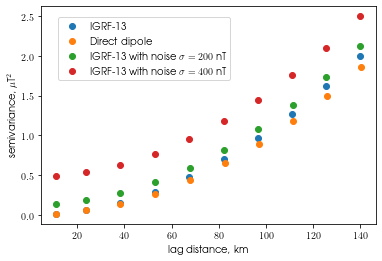

In [68]:
plt.plot(xe10_IGRF_av / 1e3, ye10_IGRF_av * 1e12, 'o', label='IGRF-13')
plt.plot(xe10_DD_av / 1e3, ye10_DD_av * 1e12, 'o', label='Direct dipole')
plt.plot(xe10_IGRF_noise200_av / 1e3, ye10_IGRF_noise200_av * 1e12, 'o', label='IGRF-13 with noise $\\sigma = 200$ nT')
plt.plot(xe10_IGRF_noise400_av / 1e3, ye10_IGRF_noise400_av * 1e12, 'o', label='IGRF-13 with noise $\\sigma = 400$ nT')
# plt.title('Empirical semivariogram in $u = \pi / 3$')
plt.xlabel('lag distance, km')
plt.ylabel('semivariance, $\\mu$T$^2$')
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0.)
plt.savefig('emp_semivars_10.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

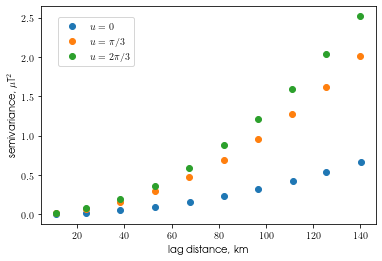

In [82]:
xe_IGRF_av, ye_IGRF_av = np.zeros_like(xe_IGRF), np.zeros_like(ye_IGRF)

for i in range(N):
    
    x, y = emp_var_u(200, 50e3, 6371e+3 + alt, 0, True, False, JD=2458940.1933954097)
    
    xe_IGRF_av += x
    ye_IGRF_av += y
    
xe_IGRF_av /= N
ye_IGRF_av /= N

x0, y0 = compress_emp_var(10, xe_IGRF_av, ye_IGRF_av)


xe_IGRF_av, ye_IGRF_av = np.zeros_like(xe_IGRF), np.zeros_like(ye_IGRF)

for i in range(N):
    
    x, y = emp_var_u(200, 50e3, 6371e+3 + alt, np.pi/3, True, False, JD=2458940.1933954097)
    
    xe_IGRF_av += x
    ye_IGRF_av += y
    
xe_IGRF_av /= N
ye_IGRF_av /= N

x2, y2 = compress_emp_var(10, xe_IGRF_av, ye_IGRF_av)

xe_IGRF_av, ye_IGRF_av = np.zeros_like(xe_IGRF), np.zeros_like(ye_IGRF)

for i in range(N):
    
    x, y = emp_var_u(200, 50e3, 6371e+3 + alt, 2*np.pi/3, True, False, JD=2458940.1933954097)
    
    xe_IGRF_av += x
    ye_IGRF_av += y
    
xe_IGRF_av /= N
ye_IGRF_av /= N

x4, y4 = compress_emp_var(10, xe_IGRF_av, ye_IGRF_av)


plt.plot(x0 / 1e3, y0 * 1e12, 'o', label='$u = 0$')
plt.plot(x2 / 1e3, y2 * 1e12, 'o', label='$u = \\pi / 3$')
plt.plot(x4 / 1e3, y4 * 1e12, 'o', label='$u = 2 \\pi / 3$')
plt.xlabel('lag distance, km')
plt.ylabel('semivariance, $\\mu$T$^2$')
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0.)
plt.savefig('atlas.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Fitting semivariogram models

In [69]:
from scipy.optimize import differential_evolution
from scipy.optimize import curve_fit

def generate_Initial_Parameters(xs, ys, func, k_range):
    
    def sumOfSquaredError(parameterTuple):
        with np.errstate(all='ignore'):
            return np.sum((ys - func(xs, *parameterTuple))**2)
    
    maxX = max(xs)
    minX = min(xs)
    maxY = max(ys)
    minY = min(ys)
    
    parameterBounds = []
    parameterBounds.append([0., maxY/2.]) # c0
    
    if func == power:
        parameterBounds.append([0., k_range]) # b
        parameterBounds.append([0., k_range]) # alpha
        
    else:
        parameterBounds.append([0., maxY]) # c
        parameterBounds.append([0., k_range*maxX]) # alpha

        if func == powered_exponential or func == matern or func == cauchy:
            parameterBounds.append([0., 20]) # nu

    result = differential_evolution(sumOfSquaredError, parameterBounds)
    return result.x

#### u = $\dfrac{\pi}{3}$

In [70]:
x, y = xe1000_IGRF, ye1000_IGRF

popt1, pcov = curve_fit(powered_exponential, x, y,
                        p0=generate_Initial_Parameters(x, y, powered_exponential, 5.), bounds=([-1,-1,1,-10], [1,1,1e8,10]))

plt.plot(x / 1e3, y * 1e12, 'o', label='Empirical')
plt.plot(x / 1e3, powered_exponential(x, *popt1) * 1e12, label='Powered exponential')
plt.plot(xe10_IGRF_av / 1e3, ye10_IGRF_av * 1e12, 'o', label='Empirical 10 points')
plt.ylabel('semivariance, $\\mu$T$^2$', fontsize=12)
plt.xlabel('lag distance, km', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('fitting_no_noise.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [71]:
print('Optimal parameters: ', popt1)

Optimal parameters:  [4.46907681e-14 2.68439170e-12 3.84153940e+05 2.79641860e+00]


In [72]:
x, y = xe1000_IGRF_noise200, ye1000_IGRF_noise200

popt3, pcov = curve_fit(powered_exponential, x, y,
                        p0=generate_Initial_Parameters(x, y, powered_exponential, 5.), bounds=([-1,-1,1,-10], [1,1,1e8,10]))

plt.plot(x / 1e3, y * 1e12, 'o', label='Empirical')
plt.plot(x / 1e3, powered_exponential(x, *popt3) * 1e12, label='Powered exponential')
plt.plot(xe10_IGRF_noise200_av / 1e3, ye10_IGRF_noise200_av * 1e12, 'o', label='Empirical 10 points')
plt.ylabel('semivariance, $\\mu$T$^2$', fontsize=12)
plt.xlabel('lag distance, km', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('fitting_noise_200.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [73]:
print('Optimal parameters: ', popt3)

Optimal parameters:  [1.27076210e-13 3.74083800e-12 4.90213904e+05 2.24337413e+00]


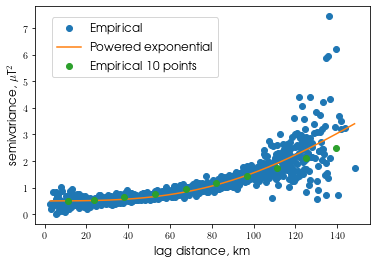

In [74]:
x, y = xe1000_IGRF_noise400, ye1000_IGRF_noise400

popt5, pcov = curve_fit(powered_exponential, x, y,
                        p0=generate_Initial_Parameters(x, y, powered_exponential, 5.), bounds=([-1,-1,1,-10], [1,1,1e8,10]))

plt.plot(x / 1e3, y * 1e12, 'o', label='Empirical')
plt.plot(x / 1e3, powered_exponential(x, *popt5) * 1e12, label='Powered exponential')
plt.plot(xe10_IGRF_noise400_av / 1e3, ye10_IGRF_noise400_av * 1e12, 'o', label='Empirical 10 points')
plt.ylabel('semivariance, $\\mu$T$^2$', fontsize=12)
plt.xlabel('lag distance, km', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('fitting_noise_400.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [75]:
print('Optimal parameters: ', popt5)

Optimal parameters:  [5.00098892e-13 6.59897289e-12 5.32550552e+05 3.04582707e+00]


## Ordinary Kriging

$$
\widehat{\mathbf{B}}\left( \mathbf{R}_\text{int} \right) = \sum\limits_j \kappa_j \mathbf{B} \left( \mathbf{R}_j \right)
$$

Coefficients $\kappa_j$ are calculated with the following system:

$$\left\{ \begin{aligned}
    &\sum\limits_{j=1}^n \kappa_j \gamma \left( \left| \mathbf{R}_i - \mathbf{R}_j \right| \right) + \varkappa = \gamma \left( \left| \mathbf{R}_i - \mathbf{R}_\text{int} \right| \right), \quad \forall i \in \{ 1, n \}\\
    &\sum\limits_{j=1}^n \kappa_j = 1.
\end{aligned} \right.$$

where

$$\gamma - \text{semivariogram model}$$

$$\varkappa - \text{Lagrange multiplier}$$

In [ ]:
def ord_kriging(Bs, Rs, R_int, func, popt):
    
    semivar_matr = np.zeros_like(Rs[0], dtype = float)

    for R in Rs:

        col = np.linalg.norm(Rs - R, axis=1)
        semivar_matr = np.vstack((semivar_matr, col))

    semivar_matr = func(semivar_matr[1:].T, *popt)
    
    semivar_vec = np.linalg.norm(Rs - R_int, axis=1)
    semivar_vec = func(semivar_vec, *popt)
    
    matrix = np.ones((Rs.shape[0]+1,Rs.shape[0]+1))
    matrix[1:,:-1] = semivar_matr
    matrix[0,-1] = 0
    
    vector = np.hstack((1, semivar_vec))
    
    coefs = (np.linalg.inv(matrix) @ vector)[:-1]
    
    sum = 0
    
    for (k, B) in zip(coefs, Bs):
        
        sum += k * B
    
    return sum

### Interpolation with Ordinary Kriging

$\textbf{Input:}$ inclination $i$, argument of latitude $u$, radius-vectors to all satellites in the swarm $\mathbf{R}^j_\text{ref orbital}$ in reference point orbital frame, semivariogram model __func__, optimal parameters for that function __popt__.

$1$. Calculate magnetic field of the $j^\text{th}$ satellite of the swarm in the reference point orbital frame: $\mathbf{B}^j_\text{ref orbital}$

$2$. Interpolate magnetic field in each point $\mathbf{R}^j_\text{ref orbital}$: $\widehat{\mathbf{B}}^j_\text{ref orbital} = \text{ord_kriging} \left( \mathbf{B}_i, \mathbf{R}_i \right), i \not = j$

$3$. Compare true value $\mathbf{B}^j_\text{ref orbital}$ with estimate $\widehat{\mathbf{B}}^j_\text{ref orbital}$

$\textbf{Output:}$ $\mathbf{B}^j_\text{ref orbital}$ and $\widehat{\mathbf{B}}^j_\text{ref orbital}$

In [ ]:
def interpolation_OK(Rs, u, func, popt):
    
    Bs_ref = np.zeros_like(Rs, dtype=float)
    Bs_ref_int = np.zeros_like(Rs, dtype=float)
    
    for (i, R) in enumerate(Rs):
        
        Bs_ref[i] = B_j_ref_orb(R, u)
        
    for (i, R) in enumerate(Rs):
        
        Rs_for_int = np.delete(Rs, i, axis=0)
        Bs_for_int = np.delete(Bs_ref, i, axis=0)
        
        Bs_ref_int[i] = ord_kriging(Bs_for_int, Rs_for_int, R, func, popt)
        
    return Bs_ref, Bs_ref_int

In [ ]:
Rs_example = np.array([[0,0,7421e+3],[0,100,7421e+3],[0,-100,7421e+3],[0,0,7421e+3+100]])

B_true_example, B_est_example = interpolation_OK(Rs_example, np.pi / 3, powered_exponential, popt1)

print('True values of magnetic field:')
print(B_true_example)
print('Estimates of magnetic field:')
print(B_est_example)

# IGRF

In [ ]:
def interpolation_OK_IGRF(Rs, u, JD, func, popt, std):
    
    Bs_ref = np.zeros_like(Rs, dtype=float)
    Bs_ref_int = np.zeros_like(Rs, dtype=float)
    
    ECEF_2_ECI = DCM_ECEF_to_ECI(JD)
    ECI_2_ORB = DCM_ECI_to_ORB(u)
    
    for (i, R) in enumerate(Rs):
        
        R_ECI = ECI_2_ORB.T @ R
        R_ECEF = ECEF_2_ECI.T @ R_ECI
        R1, R2, R3 = R_ECEF
        
        phi = np.arctan2(R2, R1)
        theta = np.arctan2(np.sqrt(R1**2 + R2**2), R3)
        r = np.sqrt(R1**2 + R2**2 + R3**2)
        
        B_ECI = magn_field_ECI_with_DCM(JD, r, theta, phi, ECEF_2_ECI)
        Bs_ref[i] = ECI_2_ORB @ B_ECI
        
    Bs_ref_meas = Bs_ref + np.random.normal(0, std, size=Bs_ref.shape)
        
    for (i, R) in enumerate(Rs):
        
        Rs_for_int = np.delete(Rs, i, axis=0)
        Bs_for_int = np.delete(Bs_ref_meas, i, axis=0)
        
        Bs_ref_int[i] = ord_kriging(Bs_for_int, Rs_for_int, R, func, popt)
        
    return Bs_ref, Bs_ref_int, Bs_ref_meas

In [ ]:
Rs_example = np.array([[0,0,7421e+3],[0,100,7421e+3],[0,-100,7421e+3],[0,0,7421e+3+100]])

B_true_example, B_est_example, _ = interpolation_OK_IGRF(Rs_example, np.pi / 3, 2458940.193395, powered_exponential, popt1, 300)

print('True values of magnetic field:')
print(B_true_example)
print('Estimates of magnetic field:')
print(B_est_example)

In [ ]:
def sats_radia_orb(u, rho, alt):
    
    return np.array([[0., 0., 6371e+3 + alt],
                     [2*rho/5 * np.cos(u) + 2*rho * np.sqrt(5/3), 0, rho/5 * np.sin(u) + 6371e+3 + alt],
                     [2*rho * np.cos(u - np.arctan(1 / np.sqrt(2))) + rho * np.sqrt(5/3),
                      rho*np.sqrt(5) * np.sin(u + np.arctan(np.sqrt(2)) - np.pi),
                      rho*np.sin(u - np.arctan(1 / np.sqrt(2))) + 6371e+3 + alt],
                     [2*rho * np.cos(u + np.arctan(1 / np.sqrt(2))) + rho * np.sqrt(5/3),
                      rho*np.sqrt(5) * np.sin(u - np.arctan(np.sqrt(2))),
                      rho*np.sin(u + np.arctan(1 / np.sqrt(2))) + 6371e+3 + alt]])

In [ ]:
def JD_add_seconds(seconds):
    
    return seconds / 24 / 3600

def julian_centuries(JD):
    
    return (JD - 2451545) / 36525

def sun_vector_ECI(JD_UTC, DUT1=-0.2):
    
    deg2rad = np.pi / 180
    
    JD_UT1 = JD_UTC + JD_add_seconds(DUT1)
    UT1_centuries = julian_centuries(JD_UT1)
    
    mean_longitude_Sun = 280.4606184 + 36000.77005361 * UT1_centuries  # [deg]
    
#     leap_seconds = 37  # [s]
#     JD_TT = JD_UTC + JD_add_seconds(32.184 + leap_seconds)
#     g = 357.53 + 0.9856003 * (JD_TT - 2451545)  # [deg]
#     g *= deg2rad  # [rad]
#     JD_TDB = JD_TT + JD_add_seconds(0.001658 * np.sin(g) + 0.000014 * np.sin(2 * g))
    
#     TDB_centuries = julian_centuries(JD_TDB)
    
    TDB_centuries = UT1_centuries
    
    mean_anomaly_Sun = 357.5277233 + 35999.05034 * TDB_centuries  # [deg]
    mean_anomaly_Sun *= deg2rad  # [rad]
    
    ecliptic_longitude = mean_longitude_Sun + 1.914666471 * np.sin(mean_anomaly_Sun) + \
                                              0.019994643 * np.sin(2 * mean_anomaly_Sun)  # [deg]
    ecliptic_longitude *= deg2rad  # [rad]
    
    mean_obliquity_ecliptic = 23.439291 - 0.0130042 * TDB_centuries  # [deg]
    mean_obliquity_ecliptic *= deg2rad  # [rad]
    
    r_Earth_to_Sun = np.array([np.cos(ecliptic_longitude),
                               np.cos(mean_obliquity_ecliptic) * np.sin(ecliptic_longitude),
                               np.sin(mean_obliquity_ecliptic) * np.sin(ecliptic_longitude)])
    
    return r_Earth_to_Sun

In [10]:
from scipy.integrate import solve_ivp

def normalize(obj):
    
    return obj / np.linalg.norm(obj)

def rot_q(q, vec, passive=True):
    
    sign = (passive * (-1.) + (not passive) * 1.)
    
    qxvec = np.cross(q[1:], vec)
    
    return q[1:] @ vec * q[1:] + q[0]**2. * vec + np.cross(q[1:], qxvec) + 2. * q[0] * qxvec * sign

def quat_product(q1, q2):
    
    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - q1[1:] @ q2[1:]
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + np.cross(q1[1:], q2[1:])
    
    return q

def omega_to_Omega(omega_0, quat, omega):
        
    mean_motion = np.array([0, omega_0, 0])
        
    return omega - rot_q(quat, mean_motion)

def cumulative_torque(quat, Omega, J, omega_0, std):
    
    eZ = rot_q(quat, np.array([0,0,1]))
    
    return 3 * omega_0**2 * np.cross(eZ, J @ eZ) + np.random.normal(0, std, 3)

def solve_motion_equation(state, T, omega_0, J, J_inv, std):
        
    def fun(u, x):
            
        quat = x[:4]
        omega = x[4:]

        Omega = omega_to_Omega(omega_0, quat, omega)
        Torque = cumulative_torque(quat, Omega, J, omega_0, std)

        x_dot = np.zeros(7)

        x_dot[4:] = J_inv @ ( Torque - np.cross(omega, J @ omega) )
        x_dot[:4] = 0.5 * quat_product(quat, np.hstack((0, Omega)))

        return x_dot

    new_state = solve_ivp(fun, (0, T), state).y[:,-1]
    new_state[:4] = normalize(new_state[:4])
    
    return new_state

def quat2rpy(quat):
    
    q0, q1, q2, q3 = quat[0], quat[1], quat[2], quat[3]
    
    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))
    
    return np.vstack((roll, pitch, yaw))

def DCM2rpy(DCM):
    
    roll = np.arctan2(DCM[1,2], DCM[2,2])
    pitch = - np.arcsin(DCM[0,2])
    yaw = np.arctan2(DCM[0,1], DCM[0,0])
    
    return np.vstack((roll, pitch, yaw))

In [12]:
J = np.diag(np.array([0.011, 0.014, 0.009]))
J_inv = np.linalg.inv(J)

print(solve_motion_equation(np.array([1,0,0,0,0,0.1,0.1]), 3, np.sqrt(3.986e+14 / (6371e+3 + 500e+3)**3), J, J_inv, 1e-7))

[0.9778561  0.0098762  0.14760423 0.1480301  0.0135886  0.09969324
 0.09929686]


In [9]:
from scipy.integrate import solve_ivp

def solve_motion_equation(state, T):
        
    def fun(u, x):
            
        quat = x[:4]
        omega = x[4:]

        Omega = self.omega_to_Omega(quat, omega)
        Torque = self.cumulative_torque(quat, Omega, isCtrl)

        x_dot = np.zeros(7)

        x_dot[4:] = dot_Ab(self.J_inv, Torque - cross(omega, dot_Ab(self.J, omega)))
        x_dot[:4] = 0.5 * quat_product(quat, np.hstack((0, Omega)))

        return x_dot

    new_state = solve_ivp(fun, (0, T), self.state).y[:,-1]
    new_state[:4] = normalize(new_state[:4])
    
    return new_state

print(solve_motion_equation(np.array([1,0,0,0,0,0.1,0.1]), 3))

[2.00824702e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.00824702e-02 2.00824702e-02]


In [8]:
print(rot_q(normalize(np.array([1,2,3,4])), np.array([-1, 4, 8])))
print(omega_to_Omega(np.sqrt(3.986e+14 / (6371e+3 + alt)**3), normalize(np.array([1,2,3,4])), np.zeros(3)))

[6. 6. 3.]
[-0.00073901  0.0003695  -0.00073901]


In [ ]:
def triad(X_body, Y_body, X_inert, Y_inert):
    
    T2_body = normalize(np.cross(X_body, Y_body))
    T2_inert = normalize(np.cross(X_inert, Y_inert))
    
    T3_body = np.cross(X_body, T2_body)
    T3_inert = np.cross(X_inert, T2_inert)
    
    R_bt = np.vstack((X_body, T2_body, T3_body)).T
    R_ti = np.vstack((X_inert, T2_inert, T3_inert))
    
    return R_bt @ R_ti

In [ ]:
# DCM_ECI_to_ORB(u,i=incl)

N = 1000
t = 0
JD = 2458940.1933954097
omega_0 = np.sqrt(3.986e+14 / (6371e+3 + alt)**3)
rho = 1430
std_magn = 400  # nT
J = np.diag(np.array([0.011, 0.014, 0.009]))
J_inv = np.linalg.inv(J)
std_torque = 1e-7
std_meas_m = 100  # nT
std_sun = 1e-9
std_meas_s = 1e-4
state_init = np.array([1,0,0,0,0,0,0])
states = np.zeros((4, N+1, 7))
states[0,0] = states[1,0] = states[2,0] = states[3,0] = state_init
B_meas = np.zeros((4,3))
S_meas = np.zeros((4,3))
DCM_model = np.zeros((4, 3, 3, N+1))
DCM_int = np.zeros((4, 3, 3, N+1))
T = 5

for i in range(N):
    
    u = omega_0 * t
    JD += JD_add_seconds(t)
    
    Rs_orb = sats_radia_orb(u, rho, alt)
    B_model, B_int, B_actual = interpolation_OK_IGRF(Rs_orb, u, JD, powered_exponential, popt1, std_magn)
    for j in range(4):
        B_meas[j] = rot_q(states[j,i,:4], B_actual[j]) + np.random.normal(0, std_meas_m, 3)
    
    S_model = DCM_ECI_to_ORB(u) @ sun_vector_ECI(JD)
    S_actual = normalize(S_model + np.random.normal(0, std_sun, 3))
    for j in range(4):
        S_meas[j] = normalize(rot_q(states[j,i,:4], S_actual) + np.random.normal(0, std_meas_s, 3))
        
    for j in range(4):
        DCM_model[j,...,i] = triad(S_meas[j], B_meas[j], S_model, B_model[j])
        DCM_int[j,...,i] = triad(S_meas[j], B_meas[j], S_model, B_int[j])
    
    for j in range(4):
        states[j,i+1] = solve_motion_equation(states[j,i], T, omega_0, J, J_inv, std_torque)
    t += T

In [ ]:
rpy_true_1 = quat2rpy(states[0,:].T)[:,:-1]
rpy_true_2 = quat2rpy(states[1,:].T)[:,:-1]
rpy_true_3 = quat2rpy(states[2,:].T)[:,:-1]
rpy_true_4 = quat2rpy(states[3,:].T)[:,:-1]

plt.plot(rpy_true_1[0])
plt.plot(rpy_true_1[1])
plt.plot(rpy_true_1[2])

In [ ]:
rpy_model_1 = DCM2rpy(DCM_model[0])[:,:-1]
rpy_model_2 = DCM2rpy(DCM_model[1])[:,:-1]
rpy_model_3 = DCM2rpy(DCM_model[2])[:,:-1]
rpy_model_4 = DCM2rpy(DCM_model[3])[:,:-1]

plt.plot(rpy_model_1[0])
plt.plot(rpy_model_1[1])
plt.plot(rpy_model_1[2])

In [ ]:
rpy_int_1 = DCM2rpy(DCM_int[0])[:,:-1]
rpy_int_2 = DCM2rpy(DCM_int[1])[:,:-1]
rpy_int_3 = DCM2rpy(DCM_int[2])[:,:-1]
rpy_int_4 = DCM2rpy(DCM_int[3])[:,:-1]

plt.plot(rpy_int_1[0])
plt.plot(rpy_int_1[1])
plt.plot(rpy_int_1[2])

In [ ]:
def delta_rpy_to_q0(rpy, q0):
    
    return 2*np.arccos(np.cos(rpy[0]/2)*np.cos(rpy[1]/2)*np.cos(rpy[2]/2)+np.sin(rpy[0]/2)*np.sin(rpy[1]/2)*np.sin(rpy[2]/2)) - 2*np.arccos(q0)

In [ ]:
N = 1000
T = 5
omega_0 = np.sqrt(3.986e+14 / (6371e+3 + alt)**3)
rho = 1430
std_magn = 600  # nT
J = np.diag(np.array([0.011, 0.014, 0.009]))
J_inv = np.linalg.inv(J)
std_torque = 1e-7
std_meas_m = 10  # nT
std_sun = 1e-9
std_meas_s = 1e-4

rpys_delta_model_1 = np.zeros((3, N))
rpys_delta_model_2 = np.zeros((3, N))
rpys_delta_model_3 = np.zeros((3, N))
rpys_delta_model_4 = np.zeros((3, N))
rpys_delta_int_1 = np.zeros((3, N))
rpys_delta_int_2 = np.zeros((3, N))
rpys_delta_int_3 = np.zeros((3, N))
rpys_delta_int_4 = np.zeros((3, N))

rpys_delta_quat_model_1 = np.zeros(N)
rpys_delta_quat_model_2 = np.zeros(N)
rpys_delta_quat_model_3 = np.zeros(N)
rpys_delta_quat_model_4 = np.zeros(N)
rpys_delta_quat_int_1 = np.zeros(N)
rpys_delta_quat_int_2 = np.zeros(N)
rpys_delta_quat_int_3 = np.zeros(N)
rpys_delta_quat_int_4 = np.zeros(N)
    
for k in range(100):    
    t = 0
    JD = 2458940.1933954097

    state_init = np.array([1,0,0,0,0,0,0])
    states = np.zeros((4, N+1, 7))
    states[0,0] = states[1,0] = states[2,0] = states[3,0] = state_init
    B_meas = np.zeros((4,3))
    S_meas = np.zeros((4,3))
    DCM_model = np.zeros((4, 3, 3, N+1))
    DCM_int = np.zeros((4, 3, 3, N+1))

    for i in range(N):

        u = omega_0 * t
        JD += JD_add_seconds(t)

        Rs_orb = sats_radia_orb(u, rho, alt)
        B_model, B_int, B_actual = interpolation_OK_IGRF(Rs_orb, u, JD, powered_exponential, popt5, std_magn)
        for j in range(4):
            B_meas[j] = rot_q(states[j,i,:4], B_actual[j]) + np.random.normal(0, std_meas_m, 3)
            B_int[j] = rot_q(states[j,i,:4], B_int[j])

        S_model = DCM_ECI_to_ORB(u) @ sun_vector_ECI(JD)
#         S_model = DCM_ECI_to_ORB(u) @ np.array([1,0,0])
        S_actual = normalize(S_model + np.random.normal(0, std_sun, 3))
        for j in range(4):
            S_meas[j] = normalize(rot_q(states[j,i,:4], S_actual) + np.random.normal(0, std_meas_s, 3))

        for j in range(4):
            DCM_model[j,...,i] = triad(S_meas[j], B_meas[j], S_model, B_model[j])
            DCM_int[j,...,i] = triad(S_meas[j], B_int[j], S_model, B_model[j])

        for j in range(4):
            states[j,i+1] = solve_motion_equation(states[j,i], T, omega_0, J, J_inv, std_torque)
        t += T
        
    rpy_true_1 = quat2rpy(states[0,:].T)[:,:-1]
    rpy_true_2 = quat2rpy(states[1,:].T)[:,:-1]
    rpy_true_3 = quat2rpy(states[2,:].T)[:,:-1]
    rpy_true_4 = quat2rpy(states[3,:].T)[:,:-1]
    rpy_model_1 = DCM2rpy(DCM_model[0])[:,:-1]
    rpy_model_2 = DCM2rpy(DCM_model[1])[:,:-1]
    rpy_model_3 = DCM2rpy(DCM_model[2])[:,:-1]
    rpy_model_4 = DCM2rpy(DCM_model[3])[:,:-1]
    rpy_int_1 = DCM2rpy(DCM_int[0])[:,:-1]
    rpy_int_2 = DCM2rpy(DCM_int[1])[:,:-1]
    rpy_int_3 = DCM2rpy(DCM_int[2])[:,:-1]
    rpy_int_4 = DCM2rpy(DCM_int[3])[:,:-1]
    
    rpys_delta_model_1 += (rpy_model_1 - rpy_true_1)**2
    rpys_delta_model_2 += (rpy_model_2 - rpy_true_2)**2
    rpys_delta_model_3 += (rpy_model_3 - rpy_true_3)**2
    rpys_delta_model_4 += (rpy_model_4 - rpy_true_4)**2
    rpys_delta_int_1 += (rpy_int_1 - rpy_true_1)**2
    rpys_delta_int_2 += (rpy_int_2 - rpy_true_2)**2
    rpys_delta_int_3 += (rpy_int_3 - rpy_true_3)**2
    rpys_delta_int_4 += (rpy_int_4 - rpy_true_4)**2
    
    rpys_delta_quat_model_1 += (delta_rpy_to_q0(rpy_model_1, states[0,:-1,0]))**2
    rpys_delta_quat_model_2 += (delta_rpy_to_q0(rpy_model_2, states[1,:-1,0]))**2
    rpys_delta_quat_model_3 += (delta_rpy_to_q0(rpy_model_3, states[2,:-1,0]))**2
    rpys_delta_quat_model_4 += (delta_rpy_to_q0(rpy_model_4, states[3,:-1,0]))**2
    rpys_delta_quat_int_1 += (delta_rpy_to_q0(rpy_int_1, states[0,:-1,0]))**2
    rpys_delta_quat_int_2 += (delta_rpy_to_q0(rpy_int_2, states[1,:-1,0]))**2
    rpys_delta_quat_int_3 += (delta_rpy_to_q0(rpy_int_3, states[2,:-1,0]))**2
    rpys_delta_quat_int_4 += (delta_rpy_to_q0(rpy_int_4, states[3,:-1,0]))**2
    
rpys_delta_model_1 = np.sqrt(rpys_delta_model_1 / 100)
rpys_delta_model_2 = np.sqrt(rpys_delta_model_2 / 100)
rpys_delta_model_3 = np.sqrt(rpys_delta_model_3 / 100)
rpys_delta_model_4 = np.sqrt(rpys_delta_model_4 / 100)
rpys_delta_int_1 = np.sqrt(rpys_delta_int_1 / 100)
rpys_delta_int_2 = np.sqrt(rpys_delta_int_2 / 100)
rpys_delta_int_3 = np.sqrt(rpys_delta_int_3 / 100)
rpys_delta_int_4 = np.sqrt(rpys_delta_int_4 / 100)
rpys_delta_quat_model_1 = np.sqrt(rpys_delta_quat_model_1 / 100)
rpys_delta_quat_model_2 = np.sqrt(rpys_delta_quat_model_2 / 100)
rpys_delta_quat_model_3 = np.sqrt(rpys_delta_quat_model_3 / 100)
rpys_delta_quat_model_4 = np.sqrt(rpys_delta_quat_model_4 / 100)
rpys_delta_quat_int_1 = np.sqrt(rpys_delta_quat_int_1 / 100)
rpys_delta_quat_int_2 = np.sqrt(rpys_delta_quat_int_2 / 100)
rpys_delta_quat_int_3 = np.sqrt(rpys_delta_quat_int_3 / 100)
rpys_delta_quat_int_4 = np.sqrt(rpys_delta_quat_int_4 / 100)

In [ ]:
plt.plot(np.arange(1000) * 12/25, rpys_delta_model_2[0] * 180 / np.pi, label='Model')
plt.plot(np.arange(1000) * 12/25, rpys_delta_int_2[0] * 180 / np.pi, label='Interpolation')
plt.xlim([0, 120])
plt.ylim([0, 9])
plt.xlabel('Argument of latitude, deg', fontsize=12)
plt.ylabel('RMSE, deg', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('rmse_roll.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
plt.plot(np.arange(1000) * 12/25, rpys_delta_model_2[1] * 180 / np.pi, label='Model')
plt.plot(np.arange(1000) * 12/25, rpys_delta_int_2[1] * 180 / np.pi, label='Interpolation')
plt.xlim([0, 120])
plt.ylim([0, 3])
plt.xlabel('Argument of latitude, deg', fontsize=12)
plt.ylabel('RMSE, deg', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('rmse_pitch.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
plt.plot(np.arange(1000) * 12/25, rpys_delta_model_2[2] * 180 / np.pi, label='Model')
plt.plot(np.arange(1000) * 12/25, rpys_delta_int_2[2] * 180 / np.pi, label='Interpolation')
plt.xlim([0, 120])
plt.ylim([0, 17])
plt.xlabel('Argument of latitude, deg', fontsize=12)
plt.ylabel('RMSE, deg', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('rmse_yaw.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
plt.plot(np.arange(1000) * 12/25, rpys_delta_quat_model_2 * 180 / np.pi, label='Model')
plt.plot(np.arange(1000) * 12/25, rpys_delta_quat_int_2 * 180 / np.pi, label='Interpolation')
plt.xlim([0, 120])
plt.ylim([0, 4])
plt.xlabel('Argument of latitude, deg', fontsize=12)
plt.ylabel('RMSE, deg', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('rmse_eigen.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
plt.plot(np.arange(1000) * 12/25, rpy_true_2[0] * 180 / np.pi, label='Roll')
plt.plot(np.arange(1000) * 12/25, rpy_true_2[1] * 180 / np.pi, label='Pitch')
plt.plot(np.arange(1000) * 12/25, rpy_true_2[2] * 180 / np.pi, label='Yaw')
plt.xlim([0, 120])
plt.ylim([-90, 60])
plt.xlabel('Argument of latitude, deg', fontsize=12)
plt.ylabel('Euler angles, deg', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('rpy_true.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
plt.plot(np.arange(1000) * 12/25, rpy_int_2[0] * 180 / np.pi, label='Roll')
plt.plot(np.arange(1000) * 12/25, rpy_int_2[1] * 180 / np.pi, label='Pitch')
plt.plot(np.arange(1000) * 12/25, rpy_int_2[2] * 180 / np.pi, label='Yaw')
plt.xlim([0, 120])
plt.ylim([-90, 60])
plt.xlabel('Argument of latitude, deg', fontsize=12)
plt.ylabel('Euler angles, deg', fontsize=12)
lgd=plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=12)
plt.savefig('rpy_int.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')